In [1]:
import os
import yaml
from IPython.display import Image
import json
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import pandas as pd
import random
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm

from paddleocr import PaddleOCR, draw_ocr
import pypdfium2 as pdfium
from PIL import Image

In [ ]:
model_version = 11 # 5 or 11
output_csv_name = 'paddle_ocr'

In [3]:
project_dir = os.path.dirname(os.getcwd())
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
output_location = os.path.join(project_dir, 'data', f'yolo_v{model_version}')
output_name = 'detection_results'

input_img_dir = dataset_location
input_txt_dir = f"{output_location}/{output_name}/labels"
output_dir = f'{output_location}/cropped_plates'


os.makedirs(output_dir, exist_ok=True)

In [4]:
source_dataset_location = dataset_location
cropped_dataset_location = output_dir
results_dir = f"{output_location}/ocr_results"
scale_dataset_location = f"{output_location}/scaled_plates"

os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

In [5]:
ocr = PaddleOCR(lang='en')

[2024/11/23 16:36:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/home/roma/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/home/roma/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length

In [6]:
import logging
logging.getLogger('ppocr').setLevel(logging.WARNING)
logging.getLogger('ppocr').setLevel(logging.ERROR)

In [7]:
for img_file in tqdm(os.listdir(cropped_dataset_location), desc='OCR'):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        # Save the processed image
        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        result = ocr.ocr(output_path, cls=True)
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'json')
        with open(output_txt_path, 'w') as f:
            txt = ""
            for idx in range(len(result)):
                res = result[idx]
                # Print the OCR result
                if res is not None:
                    for line in res:
                        txt += line[-1][0]
            dict_lst = [{'Text' : txt, 'Probability' : 100}]
            json.dump(dict_lst, f)


OCR: 100%|██████████| 386/386 [00:43<00:00,  8.94it/s]


In [8]:
df_true_location = f'{dataset_location}/output.csv'
df_true = pd.read_csv(df_true_location)
df_true['picture_name'] = df_true['picture_name'].apply(lambda x: 'plate_'+x)
df_true.set_index('picture_name', inplace=True)
df_true.head()

,text
picture_name,
plate_00808.jpg,046TS
plate_01433.jpg,912FB
plate_01063.jpg,044FF
plate_01576.jpg,M496T
plate_00263.jpg,155DW


In [9]:
df_pred_location = f'{output_location}/{output_csv_name}_pred.csv'
plate_numbers = []
plate_strings = []

threshold = 0.6

for ocr_file in os.listdir(results_dir):
    with open(os.path.join(results_dir, ocr_file), 'r') as f:
        plt_str = ''
        results = json.load(f)
        for result in results:
            if float(result['Probability']) > threshold:
                plt_str += result['Text']
        plt_str = plt_str.replace(" ", "").upper()
        plate_strings.append(plt_str)
        plate_numbers.append(ocr_file.split('.')[0]+'.jpg')

df_pred = pd.DataFrame({'picture_name':plate_numbers, 'text':plate_strings})
df_pred.to_csv(df_pred_location)
df_pred.set_index('picture_name', inplace=True)
df_pred.head()

,text
picture_name,
plate_01772.jpg,DN344
plate_00694.jpg,238BGWWW.AUTO
plate_00978.jpg,WP19
plate_01461.jpg,881L
plate_00857.jpg,HY659


In [10]:
import pandas as pd
from difflib import SequenceMatcher
from sklearn.metrics import f1_score, precision_score, recall_score

# Merging dataframes on 'picture_name' index to only evaluate overlapping entries
df_merged = df_true.join(df_pred, lsuffix='_true', rsuffix='_pred', how='inner')

# 1. Accuracy (Exact Match)
exact_matches = (df_merged['text_true'] == df_merged['text_pred']).sum()
accuracy = exact_matches / len(df_merged)

# 2. Levenshtein Distance (Edit Distance) - Using SequenceMatcher
def levenshtein_ratio(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

df_merged['levenshtein_ratio'] = df_merged.apply(lambda row: levenshtein_ratio(row['text_true'], row['text_pred']), axis=1)
average_levenshtein_ratio = df_merged['levenshtein_ratio'].mean()

# 3. Character-Level Precision, Recall, F1 Score
def calculate_char_level_scores(true_text, pred_text):
    # Creating sets of characters for precision, recall, F1
    true_chars = set(true_text)
    pred_chars = set(pred_text)
    
    true_positive = len(true_chars & pred_chars)
    precision = true_positive / len(pred_chars) if pred_chars else 0
    recall = true_positive / len(true_chars) if true_chars else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Calculate character-level scores for each entry
df_merged[['char_precision', 'char_recall', 'char_f1']] = df_merged.apply(
    lambda row: pd.Series(calculate_char_level_scores(row['text_true'], row['text_pred'])), axis=1
)

# Aggregate the results
average_precision = df_merged['char_precision'].mean()
average_recall = df_merged['char_recall'].mean()
average_f1_score = df_merged['char_f1'].mean()

# Output results
print(f"Accuracy (Exact Match): {accuracy:.2f}")
print(f"Average Levenshtein Ratio: {average_levenshtein_ratio:.2f}")
print(f"Character-Level Precision: {average_precision:.2f}")
print(f"Character-Level Recall: {average_recall:.2f}")
print(f"Character-Level F1 Score: {average_f1_score:.2f}")

df_merged_loaction = f'{output_location}/merged.csv'
df_merged.to_csv(df_merged_loaction)


Accuracy (Exact Match): 0.32
Average Levenshtein Ratio: 0.70
Character-Level Precision: 0.83
Character-Level Recall: 0.84
Character-Level F1 Score: 0.82


{'Text': '698MM', 'Probability': 100}


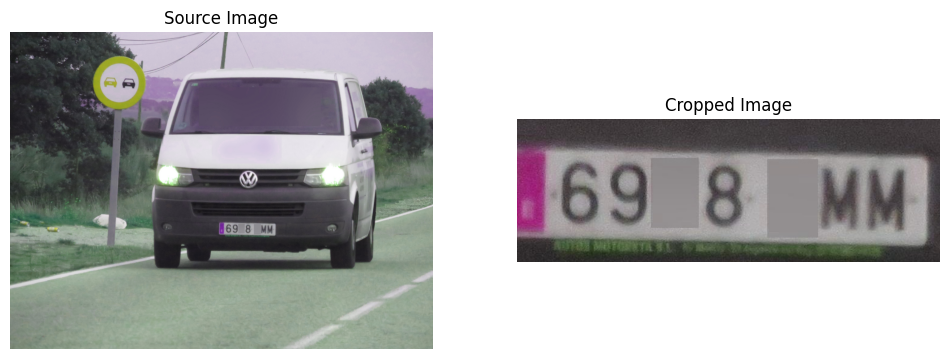

{'Text': 'S102K', 'Probability': 100}


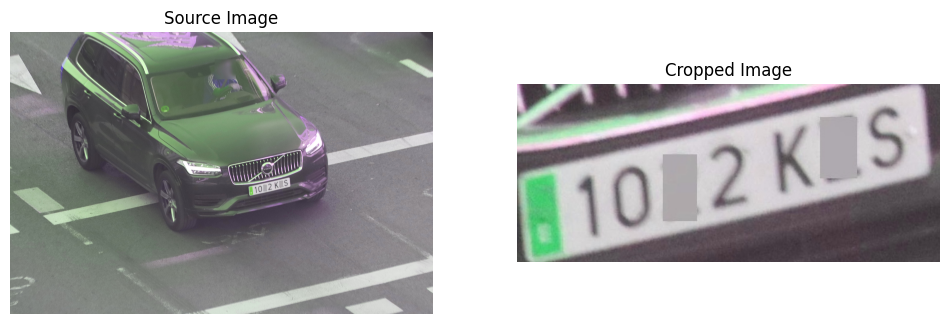

{'Text': '710PD', 'Probability': 100}


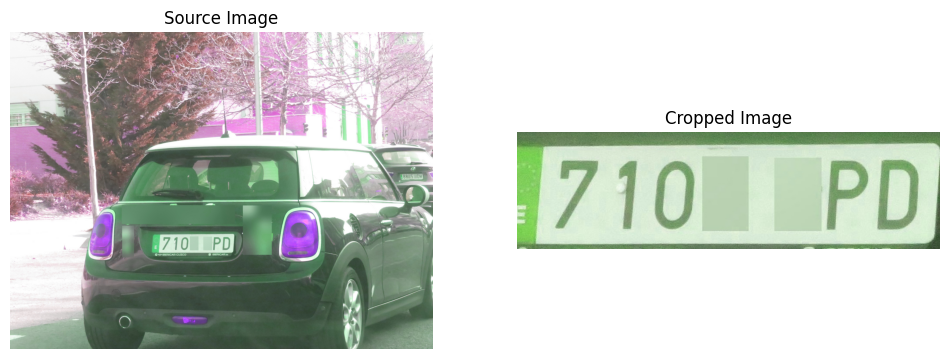

{'Text': 'HH736', 'Probability': 100}


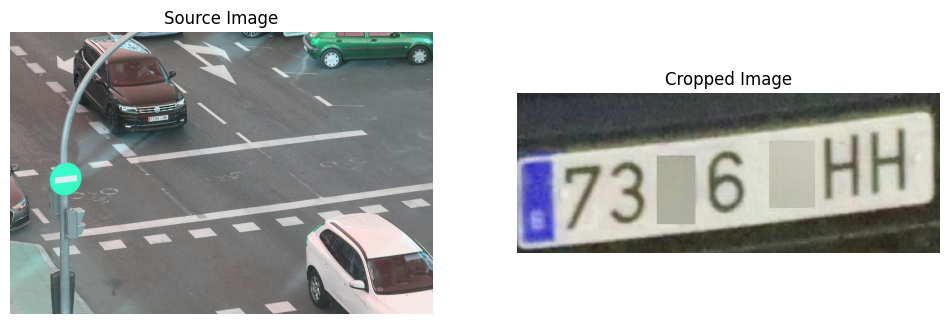

{'Text': '785GZ', 'Probability': 100}


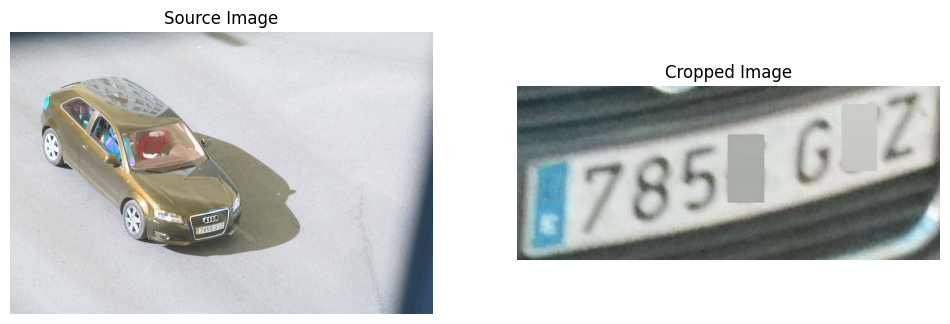

{'Text': 'M199', 'Probability': 100}


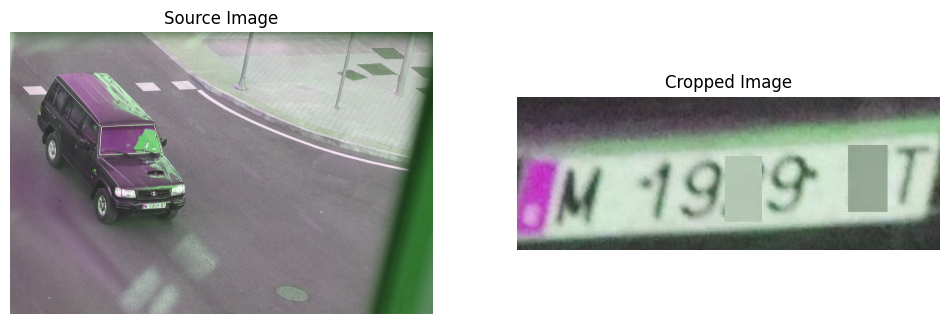

{'Text': '09DRE', 'Probability': 100}


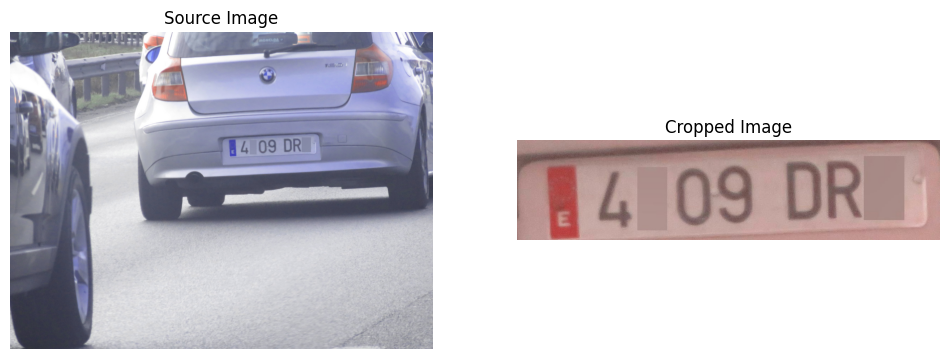

{'Text': '3557PZ', 'Probability': 100}


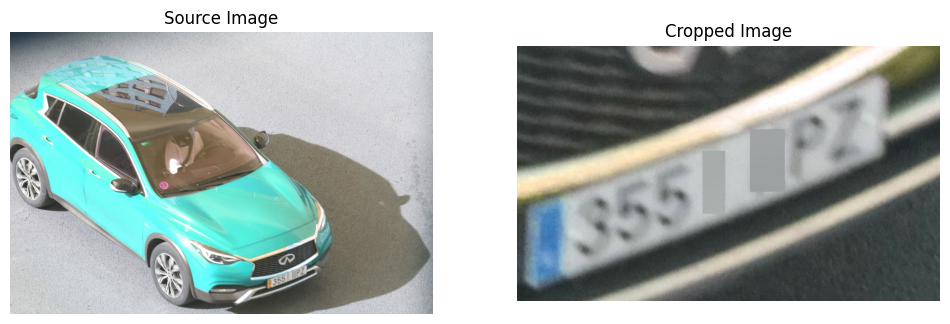

{'Text': '124DF', 'Probability': 100}


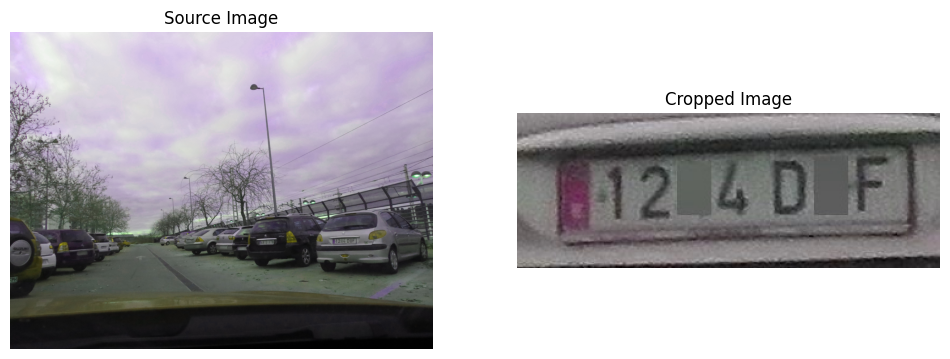

{'Text': 'M668S', 'Probability': 100}


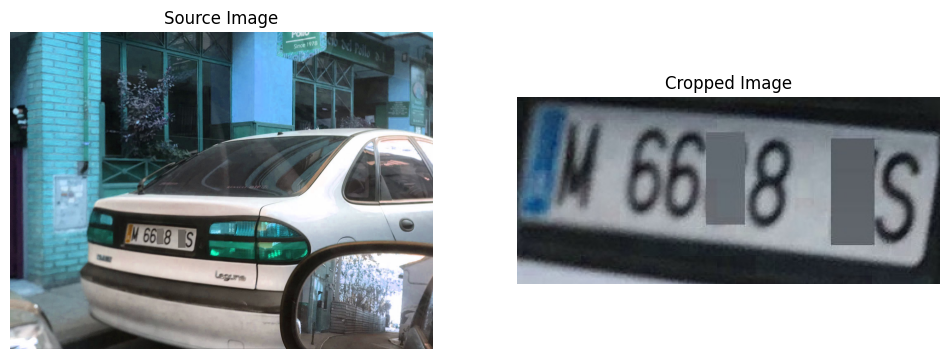

In [11]:
import random

first_dataset = source_dataset_location
second_dataset = scale_dataset_location

# start_index = 0
start_index = random.randint(0, len(os.listdir(second_dataset)))

for img_file in os.listdir(second_dataset)[start_index:start_index+10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'json')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = json.load(f)
            for result in results:
                print(result)
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.show()